# **Model Training**  
**A Deep Learning Approach To Automate Photo-Id Tagging Of Whales And Dolphins**

## **1. Importing the dependencies**

In [ ]:
!pip install -q efficientnet
!pip install -q tensorflow_addons
!pip install tfimm

     |████████████████████████████████| 50 kB 2.0 MB/s 
     |████████████████████████████████| 1.1 MB 5.0 MB/s 
     |████████████████████████████████| 139 kB 4.1 MB/s 
     |████████████████████████████████| 462 kB 9.0 MB/s 


In [ ]:
import numpy as np
import pandas as pd
import re, os, random, math
import tensorflow as tf
import efficientnet.tfkeras as efn
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras import backend as K
from tensorflow.keras.layers import BatchNormalization, Input, GlobalAveragePooling2D, Dropout, Dense, Softmax
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy
from tensorflow.keras.callbacks import LearningRateScheduler, CSVLogger, ModelCheckpoint,Callback
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import pickle, json
import tensorflow_hub as tfhub
from datetime import datetime

In [ ]:
print(f"\n... ACCELERATOR SETUP STARTING ...\n")

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    TPU = tf.distribute.cluster_resolver.TPUClusterResolver()  
except ValueError:
    TPU = None

if TPU:
    print(f"\n... RUNNING ON TPU - {TPU.master()}...")
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy = tf.distribute.experimental.TPUStrategy(TPU)
else:
    print(f"\n... RUNNING ON CPU/GPU ...")
    # Yield the default distribution strategy in Tensorflow
    #   --> Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy() 

# What Is a Replica?
#    --> A single Cloud TPU device consists of FOUR chips, each of which has TWO TPU cores. 
#    --> Therefore, for efficient utilization of Cloud TPU, a program should make use of each of the EIGHT (4x2) cores. 
#    --> Each replica is essentially a copy of the training graph that is run on each core and 
#        trains a mini-batch containing 1/8th of the overall batch size
N_REPLICAS = strategy.num_replicas_in_sync
    
print(f"... # OF REPLICAS: {N_REPLICAS} ...\n")

AUTO = tf.data.experimental.AUTOTUNE

print(f"\n... ACCELERATOR SETUP COMPLTED ...\n")


... ACCELERATOR SETUP STARTING ...


... RUNNING ON TPU - grpc://10.126.139.210:8470...
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.126.139.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.126.139.210:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


... # OF REPLICAS: 8 ...


... ACCELERATOR SETUP COMPLTED ...



In [ ]:
print(f"\n... XLA OPTIMIZATIONS STARTING ...\n")

print(f"\n... CONFIGURE JIT (JUST IN TIME) COMPILATION ...\n")
# enable XLA optmizations (10% speedup when using @tf.function calls)
tf.config.optimizer.set_jit(True)

print(f"\n... XLA OPTIMIZATIONS COMPLETED ...\n")


... XLA OPTIMIZATIONS STARTING ...


... CONFIGURE JIT (JUST IN TIME) COMPILATION ...


... XLA OPTIMIZATIONS COMPLETED ...



## **2. Configuration and Versions**

In [ ]:
class CFG:
    
    SEED = 42
    FOLD_TO_RUN = 0   # To seperate train/validation dataset
    FOLDS = 5 # If FOLDS == FOLD_TO_RUN, using all data for trainning
    DEBUG = False  # If True, get out some data to run model
    EVALUATE = True
    
    ### Dataset
    GCS_PATH = 'happywhale-cropped-removebackground-tfrecords-v1'
    BATCH_SIZE = 8 * N_REPLICAS
    IMAGE_SIZE = 768
    N_CLASSES = 15587
    
    ### Model
    model_type = f'effnetv2'
    EFNS = [efn.EfficientNetB0, efn.EfficientNetB1, efn.EfficientNetB2, efn.EfficientNetB3, 
            efn.EfficientNetB4, efn.EfficientNetB5, efn.EfficientNetB6, efn.EfficientNetB7]
    EFF_NET = 7 # choose EfficientV1
    EFF_NETV2 = f'efficientnetv2-xl-21k-ft1k'
    FREEZE_BATCH_NORM = False # Choose inference or 
    head = 'arcface' # head layer in model
    EPOCHS = 25
    LR = 0.001
    message='baseline'
    RESUME = False # Resume learning from the checkpoint
    
    ### Augmentations
    CUTOUT = False
    N_CUTOUT = 6
    ### Inference
    KNN = 100
    
    ###Learning Rate Scheduler
    RESUME_EPOCH = 9
    
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)
    
# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
def is_interactive():
    return 'runtime'    in get_ipython().config.IPKernelApp.connection_file
IS_INTERACTIVE = is_interactive()
print(IS_INTERACTIVE)

True


In [ ]:
MODEL_NAME = None
if CFG.model_type == 'effnetv1':
    MODEL_NAME = f'effnetv1_b{CFG.EFF_NET}'
elif CFG.model_type == 'effnetv2':
    MODEL_NAME = f'effnetv2_{CFG.EFF_NETV2}'

CFG.MODEL_NAME = MODEL_NAME
print(MODEL_NAME)

effnetv2_efficientnetv2-xl-21k-ft1k


In [ ]:
print("\n... DATA ACCESS SETUP STARTED ...\n")
# Choose the 
#GCS_PATH = KaggleDatasets().get_gcs_path(CFG.GCS_PATH)
GCS_PATH = "gs://kds-f0a3ffcf37278c13ed2d96c571e8c6746bd2178ba7b16692dd0652c8"
train_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-train*.tfrec')))
test_files = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/happywhale-2022-test*.tfrec')))

print(count_data_items(train_files),count_data_items(test_files))
    
print("\n\n... DATA ACCESS SETUP COMPLETED ...\n")


... DATA ACCESS SETUP STARTED ...

51033 27956


... DATA ACCESS SETUP COMPLETED ...



## **3. Dataset**

****
1. Happy whale-splits

This dataset is created by @ks2019 with code:
```
train_df = pd.read_csv('../input/happy-whale-and-dolphin/train.csv')
train_df.species.replace({"globis": "short_finned_pilot_whale",
                          "pilot_whale": "short_finned_pilot_whale",
                          "kiler_whale": "killer_whale",
                          "bottlenose_dolpin": "bottlenose_dolphin"}, inplace=True)
train_df.to_csv('train_fixed.csv',index=False)

train_df = pd.read_csv('train_fixed.csv')
train_df['individual_id'] = train_df['individual_id'].map(individual_ids)
train_df['species'] = train_df['species'].map(species)
skf = StratifiedKFold(n_splits=5,random_state=123)
for fold,(train_index, test_index) in enumerate(skf.split(train_df, train_df.species)):
    train_df.loc[test_index,'fold'] = fold
print(train_df.groupby('fold').individual_id.nunique().to_dict())
print(train_df.groupby('fold').species.nunique().to_dict())
print(train_df.groupby('fold').image.nunique().to_dict())
train_df.to_csv('skf_species_5folds.csv',index=False)
```


 2. TFRecords 

https://www.kaggle.com/datasets/phanttan/happywhale-cropped-removebackground-tfrecords-v1


## **4. Utility Functions**

### 4.1. ArcFace

In [ ]:
def arcface_format(posting_id, image, label_group, matches):
    return posting_id, {'Input1': image, 'Input2': label_group}, label_group, matches

def arcface_inference_format(posting_id, image, label_group, matches):
    return image,posting_id

def arcface_eval_format(posting_id, image, label_group, matches):
    return image,label_group

### 4.2. Data Augmentation 

In [ ]:
def data_augment(posting_id, image, label_group, matches):
    ### CUTOUT
    if tf.random.uniform([])>0.5 and CFG.CUTOUT:
        for cutouts in range(CFG.N_CUTOUT):
            if tf.random.uniform([])>0.5:
               DIM = CFG.IMAGE_SIZE
               CUTOUT_LENGTH = DIM//8
               x1 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
               x2 = tf.cast( tf.random.uniform([],0,DIM-CUTOUT_LENGTH),tf.int32)
               filter_ = tf.concat([tf.zeros((x1,CUTOUT_LENGTH)),tf.ones((CUTOUT_LENGTH,CUTOUT_LENGTH)),tf.zeros((DIM-x1-CUTOUT_LENGTH,CUTOUT_LENGTH))],axis=0)
               filter_ = tf.concat([tf.zeros((DIM,x2)),filter_,tf.zeros((DIM,DIM-x2-CUTOUT_LENGTH))],axis=1)
               cutout = tf.reshape(1-filter_,(DIM,DIM,1))
               image = cutout*image

    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return posting_id, image, label_group, matches

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, [CFG.IMAGE_SIZE,CFG.IMAGE_SIZE])
    image = tf.cast(image, tf.float32) / 255.0
    return image

# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64),
#         "matches": tf.io.FixedLenFeature([], tf.string)
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    posting_id = example['image_name']
    image = decode_image(example['image'])
#     label_group = tf.one_hot(tf.cast(example['label_group'], tf.int32), depth = N_CLASSES)
    label_group = tf.cast(example['target'], tf.int32)
#     matches = example['matches']
    matches = 1
    return posting_id, image, label_group, matches

### 4.3. TF Records to Tensors Functions

In [ ]:
def load_dataset(filenames, ordered = False):
    """Loading Dataset from dataset: happywhale-tfrecords-v1.

    Parameters
    ----------
    label : string
            The true label of the image
    predictions : list
            A list of predicted elements (order does matter, 5 predictions allowed per image)

    Returns
    -------
    score : double
    """    
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# Get Dataset with some configurations for Training
def get_training_dataset(filenames):
    dataset = load_dataset(filenames, ordered = False)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(CFG.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# Get Dataset with some configurations for Validation
def get_val_dataset(filenames):
    dataset = load_dataset(filenames, ordered = True)
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.map(arcface_format, num_parallel_calls = AUTO)
    dataset = dataset.map(lambda posting_id, image, label_group, matches: (image, label_group))
    dataset = dataset.batch(CFG.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

## **5. Model Building**

In [ ]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.
    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):
        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])
        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(tf.math.l2_normalize(X, axis=1),
                           tf.math.l2_normalize(self.W, axis=0))
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
            one_hot = tf.cast(tf.one_hot(y, depth=self.n_classes),
                              dtype=cosine.dtype)
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output 

In [ ]:
# BatchNormalization Mode Function
def freeze_BN(model):
    # Unfreeze all Layers except for Batch Norm
    for layer in model.layers:
        if not isinstance(layer, BatchNormalization):
            layer.trainable = True 
        else:
            layer.trainable = False # in inference mode
    return model

In [ ]:
# Create EfficientNetB7 Model
def get_model():
    if CFG.head == "arcface":
        head = ArcMarginProduct
    else:
        assert 2021==2022 , "INVALID HEAD IN MODEL"
        
    with strategy.scope():
        margin = head(n_classes=CFG.N_CLASSES,
                      s=30, 
                      m=0.3, 
                      name=f'head/{CFG.head}', 
                      dtype='float32'
                     )
        inp = Input(shape = [CFG.IMAGE_SIZE, CFG.IMAGE_SIZE, 3], name = 'Input1')
        label = Input(shape=(), name='Input2')
        if CFG.model_type == 'effnetv1':
            x = CFG.EFNS[CFG.EFF_NET](weights = 'noisy-student', include_top = False)(inp)
            embed = GlobalAveragePooling2D()(x)
        elif CFG.model_type == 'effnetv2':
            #GCS_WEIGHTS_PATH = KaggleDatasets().get_gcs_path('efficientnetv2-tfhub-weight-files')
            GCS_WEIGHTS_PATH = 'gs://kds-63d1ff0b998a13906a20d228c6bf4a1e4100f856a5c115774b70ea8d'
            FEATURE_VECTOR = f'{GCS_WEIGHTS_PATH}/tfhub_models/{CFG.EFF_NETV2}/feature_vector'
            embed = tfhub.KerasLayer(FEATURE_VECTOR, trainable=True)(inp)
        else:
            embed = tfimm.create_model(CFG.model_type, pretrained="timm")(inp)

        embed = Dropout(0.3)(embed)
        embed = Dense(1024)(embed)
        x = margin([embed, label])
        
        output = Softmax(dtype='float32')(x)
        
        model = Model(inputs = [inp, label], outputs = [output])
        embed_model = Model(inputs = inp, outputs = embed)  
        
        opt = tf.keras.optimizers.Adam(learning_rate = CFG.LR)
        if CFG.FREEZE_BATCH_NORM:
            freeze_BN(model)

        model.compile(
            optimizer = opt,
            loss = [SparseCategoricalCrossentropy()],
            metrics = [SparseCategoricalAccuracy(),SparseTopKCategoricalAccuracy(k=5)]
            ) 
        
        return model,embed_model

## **6. Model Callbacks**

In [ ]:
training_filenames = [x for i,x in enumerate(train_files) if i%CFG.FOLDS!=CFG.FOLD_TO_RUN]
validation_filenames = [x for i,x in enumerate(train_files) if i%CFG.FOLDS==CFG.FOLD_TO_RUN]
del train_files

In [ ]:
def get_lr_callback(plot=False):
    lr_start   = 0.000001
    lr_max     = 0.000005 * CFG.BATCH_SIZE  
    lr_min     = 0.000001
    lr_ramp_ep = 4
    lr_sus_ep  = 0
    lr_decay   = 0.9
   
    def lrfn(epoch):
        if CFG.RESUME:
            epoch = epoch + CFG.RESUME_EPOCH

        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start    
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(CFG.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback


class Snapshot(Callback):
    def __init__(self,fold,snapshot_epochs=[]):
        super(Snapshot, self).__init__()
        self.snapshot_epochs = snapshot_epochs
        self.fold = fold
        
    def on_epoch_end(self, epoch, logs=None):
        if epoch in self.snapshot_epochs: # your custom condition         
            self.model.save_weights(f"./EF{CFG.MODEL_NAME}_epoch{epoch}.h5")
        self.model.save_weights(f"./{CFG.MODEL_NAME}_last.h5")    

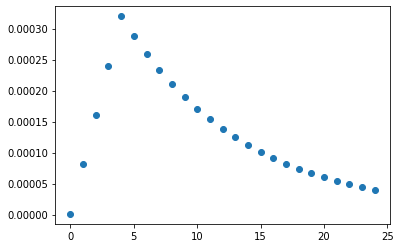

In [ ]:
seed_everything(CFG.SEED)
train_dataset = get_training_dataset(training_filenames)
val_dataset = get_val_dataset(validation_filenames)
STEPS_PER_EPOCH = count_data_items(training_filenames)//CFG.BATCH_SIZE

## Logging
train_logger = CSVLogger('./training-log-fold-%i.h5.csv'%CFG.FOLD_TO_RUN)

# SAVE BEST MODEL EACH FOLD
sv_loss = ModelCheckpoint(f"./{CFG.MODEL_NAME}_loss_{CFG.FOLD_TO_RUN}.h5", 
                          monitor='val_loss', 
                          verbose=0, 
                          save_best_only=True, 
                          save_weight_only=True, mode='min', save_freq='epoch')
                          
# Snapshot
snap = Snapshot(fold=CFG.FOLD_TO_RUN,snapshot_epochs=[5,8])
# Learning Rate Scheduler
get_lr_callback(plot=True);

## **7. Model Training**

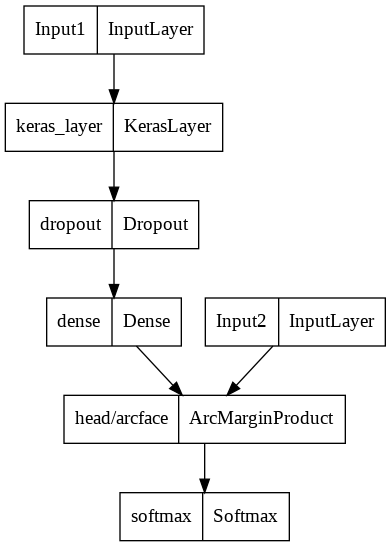

In [ ]:
# Build Model
K.clear_session()
model, embed_model = get_model()
plot_model(model)

In [ ]:
print("--- Size Image %i with %str and Batchsize %i ---"%(CFG.IMAGE_SIZE, CFG.EFF_NETV2, CFG.BATCH_SIZE))

####-------------In the last, we trained model and save the log data in Server---------- ###
history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    steps_per_epoch=STEPS_PER_EPOCH, 
                    epochs=CFG.EPOCHS, 
                    callbacks=[snap, get_lr_callback(), train_logger, sv_loss], 
                    verbose=1)
###-------------Loading the previous results----------------###

--- Size Image 768 with efficientnetv2-xl-21k-ft1ktr and Batchsize 64 ---
Epoch 1/25
637/637 [==============================] - 1107s 1s/step - loss: 18.9123 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 18.7280 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00


2022-04-25 03:05:05.306853: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 113893, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1650855905.303478135","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 113893, Output num: 0","grpc_status":3}


Epoch 2/25
637/637 [==============================] - 740s 1s/step - loss: 18.2170 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 0.0000e+00 - val_loss: 17.8962 - val_sparse_categorical_accuracy: 0.0000e+00 - val_sparse_top_k_categorical_accuracy: 0.0000e+00
Epoch 3/25
637/637 [==============================] - 739s 1s/step - loss: 17.3061 - sparse_categorical_accuracy: 0.0000e+00 - sparse_top_k_categorical_accuracy: 1.4620e-06 - val_loss: 16.9879 - val_sparse_categorical_accuracy: 0.0047 - val_sparse_top_k_categorical_accuracy: 0.0059
Epoch 4/25
637/637 [==============================] - 740s 1s/step - loss: 16.3634 - sparse_categorical_accuracy: 2.5106e-04 - sparse_top_k_categorical_accuracy: 6.5868e-04 - val_loss: 16.7992 - val_sparse_categorical_accuracy: 0.0088 - val_sparse_top_k_categorical_accuracy: 0.0125
Epoch 5/25
637/637 [==============================] - 741s 1s/step - loss: 15.3607 - sparse_categorical_accuracy: 0.0015 - sparse_top_k_categor

In [ ]:
# Saving the Model weight.
try:
    model.save_weights("model.h5")
    print("Saved model to Drive")
    model_json = model.to_json()
    with open("model.json", "w") as json_file:
        json_file.write(model_json)
except Exception:
    print('Failed to Save')

Saved model to Drive


<AxesSubplot:>

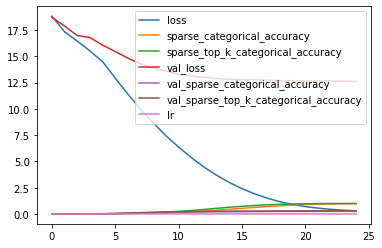

In [ ]:
df_hist = pd.DataFrame(model.history.history)
df_hist.to_csv('history.csv')
df_hist.plot()